# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## 0. Описание проекта

**Условия задачи:**

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Описание данных**
* Данные геологоразведки трёх регионов находятся в файлах:
 - geo_data_0.csv. Скачать датасет
 - geo_data_1.csv. Скачать датасет
 - geo_data_2.csv. Скачать датасет
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей).


## 1. Загрузка и подготовка данных

### 1.1 Импорт библиотек и объявление констант

In [1]:
import os

# для работы со структурами данных
import pandas as pd
# разделение датасета на данные для обучения и тестирования
from sklearn.model_selection import train_test_split
# модель
from sklearn.linear_model import LinearRegression
# для расчета  mse
from sklearn.metrics import  mean_squared_error
# для использовоания RandomState
import numpy as np
from numpy.random import RandomState

# для выч. коэф.детерминации
from sklearn.metrics import r2_score 
# для доверит. интерв         
import scipy as sp
#import scipy.stats
from scipy import stats as st

#для визуализации
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# импортируем классы для опредлеления нормальности распределения
from scipy.stats import shapiro, normaltest



In [2]:
#константа локального пути
LOCAL_DATA_PATH = 'c:/ps/project/HR/data/'

#константа пути в тренажере
TRAINER_DATA_PATH = '/datasets/'

#список имен датафреймов
DF_NAMES = ['geo_data_0', 'geo_data_1', 'geo_data_2']

# константа новой строки для использования в f' строках
NL = '\n'


RANDOM_STATE = RandomState(12345) 

### 1.2 Импорт данных

In [3]:
for f in DF_NAMES:
    if os.path.exists(LOCAL_DATA_PATH):
        globals()[f] = pd.read_csv(LOCAL_DATA_PATH + f + '.csv', index_col='id')
    elif os.path.exists(TRAINER_DATA_PATH):
        globals()[f] = pd.read_csv(TRAINER_DATA_PATH + f + '.csv', index_col='id')
    else:
        print('Warning: no files found')

In [4]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].sample(5))

Датасет geo_data_0


,f0,f1,f2,product
id,,,,
RXjxS,0.490886,0.979717,4.536697,151.711814
FdQj9,0.635556,0.682057,7.084134,162.158895
pSkYX,0.056520,0.305842,3.619152,24.594578
ojTzH,-0.633881,0.739882,0.031143,26.312535
ZuyGS,-0.647279,0.786759,-0.368287,39.123950


Датасет geo_data_1


,f0,f1,f2,product
id,,,,
NloTz,0.930798,-2.690107,4.988253,134.766305
0yb3i,10.601376,1.295833,5.000835,134.766305
7RV6E,-12.208972,-2.113489,1.995931,57.085625
Mk4XH,-5.128433,-9.405826,1.003554,30.132364
qaVl1,-0.844614,-5.438688,5.001764,137.945408


Датасет geo_data_2


,f0,f1,f2,product
id,,,,
li0wx,0.210612,-0.698241,2.229495,38.900435
M7HUs,0.325133,2.012051,4.340149,133.769881
nNh15,1.590349,1.890934,1.739540,84.437010
c0OyP,-0.281187,-0.979475,7.106227,105.494730
WPR6D,1.604862,-0.077978,2.303576,40.684789


**Существующие столбцы и информация, которую они содержат:**

- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек
- product — объём запасов в скважине (тыс. баррелей)

**Рассмотрим данные геологоразведки более детально:**

### 1.3 Анализ данных

In [5]:
# Первый регион
print(geo_data_0.info())
print(geo_data_0.describe())
geo_data_0.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347


0

В ***первом*** регионе пропуски отсутствуют, признаки имееют одинаковый масштаб данных, дубликатов нет. Также можно отметить, что средние в признаках очень близки к медианным значениям, поэтому скорее всего, в данных нет выбросов/аномальных значений.

In [6]:
# Второй регион
print(geo_data_1.info())
print(geo_data_1.describe())
geo_data_1.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408


0

Во ***втором*** регионе пропуски отсутствуют, признаки имееют одинаковый масштаб данных, дубликатов нет. Также можно отметить, что средние в признаках очень близки к медианным значениям, поэтому скорее всего, в данных нет выбросов/аномальных значений. Это касается всех признаков, кроме признака ***f2***, в котором среднее 2.49 отличается от медианы 2.01, здесь могут иметь место выбросы/аномалии.

In [7]:
# Третий регион
print(geo_data_2.info())
print(geo_data_2.describe())
geo_data_2.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838


0

Во ***третьем*** регионе пропуски отсутствуют, признаки имееют одинаковый масштаб данных, дубликатов нет. Также можно отметить, что среднее в признаке ***f2*** очень близко к медианному значению, поэтому скорее всего, в данных нет выбросов/аномальных значений. Это касается всех признаков, кроме признаков ***f0 и f1*** - средние отличаются от медиан, здесь могут иметь место выбросы/аномалии.

In [8]:
#Уникальные значения таблиц
display(geo_data_0.nunique())
display(geo_data_1.nunique())
display(geo_data_2.nunique())

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

f0         100000
f1         100000
f2         100000
product        12
dtype: int64

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

У второго датасета уникальных значений в целевом признаке `product` всего 12. Посмотрим как это отразится на предсказаниях модели.

посмотрим на матрицы корреляции признаков по датасетам:

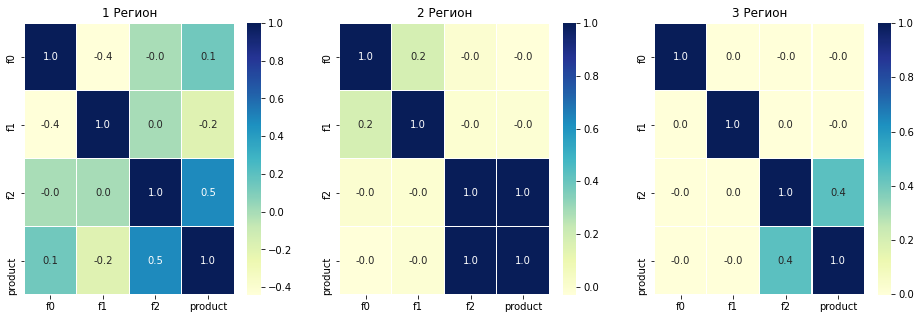

In [9]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for i,j in zip([geo_data_0, geo_data_1, geo_data_2],range(3)):    
    sns.heatmap(i.corr(),annot=True, linewidths=.1, fmt= '.1f', ax=ax[j], cmap="YlGnBu")
    ax[j].set_title(str(j+1) + ' Регион')

Признак f2 очень сильно коррелирует с product, особенно во втором датасете.

### 1.4 Построение графиков для количественных признаков 

У нас все признаки количественные, поэтому построим для  них пару графиков: гистограмму и boxplot, кроме того, проверим распределения на нормальность с помощью shapiro.

"Пара графиков для таблицы geo_data_0


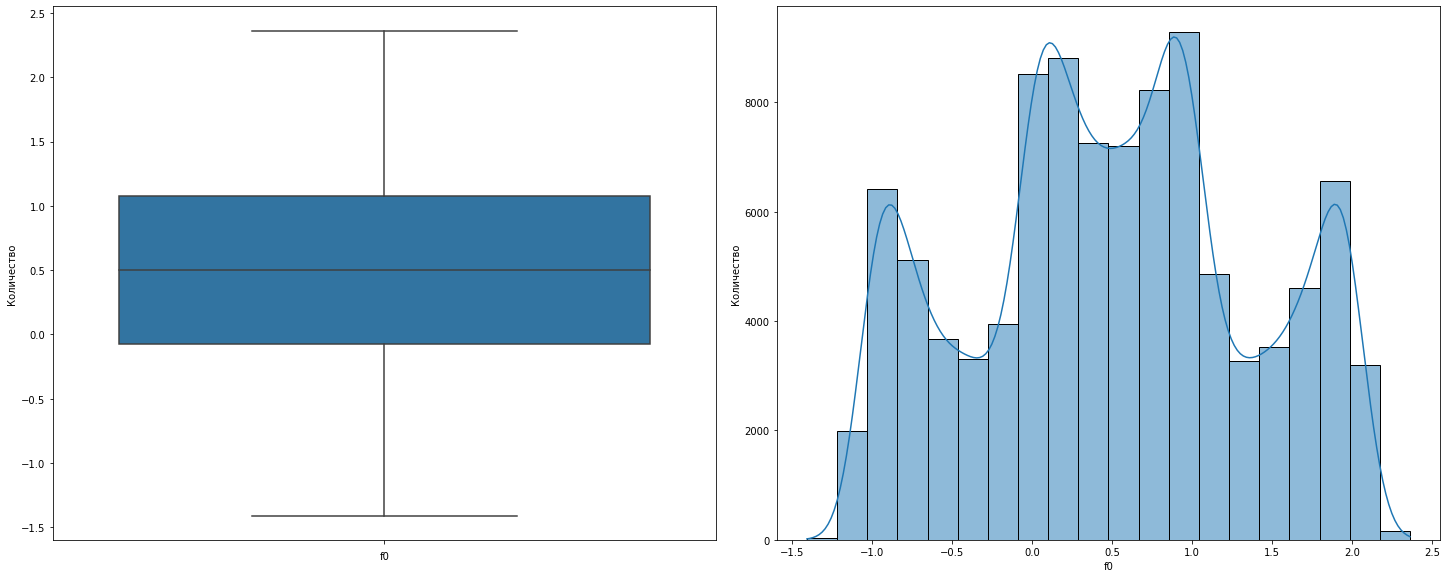

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=0.972, p=0.000\n'

Probably not Gaussian


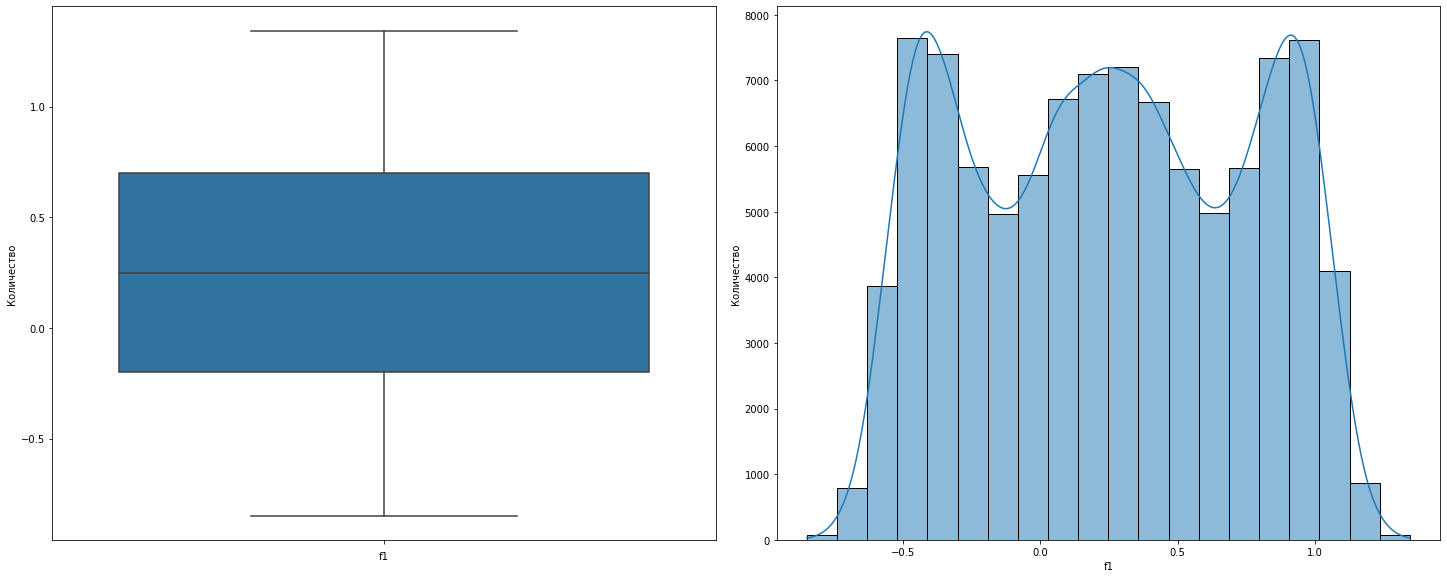

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=0.957, p=0.000\n'

Probably not Gaussian


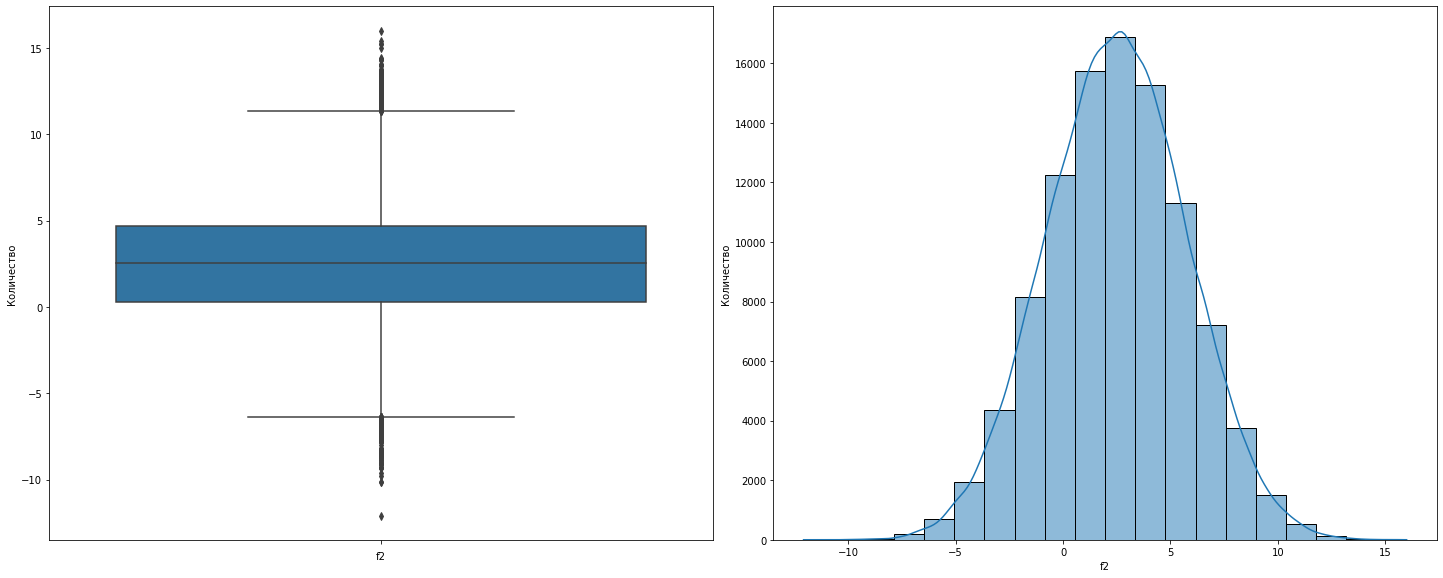

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=1.000, p=0.000\n'

Probably not Gaussian
"Пара графиков для таблицы geo_data_1


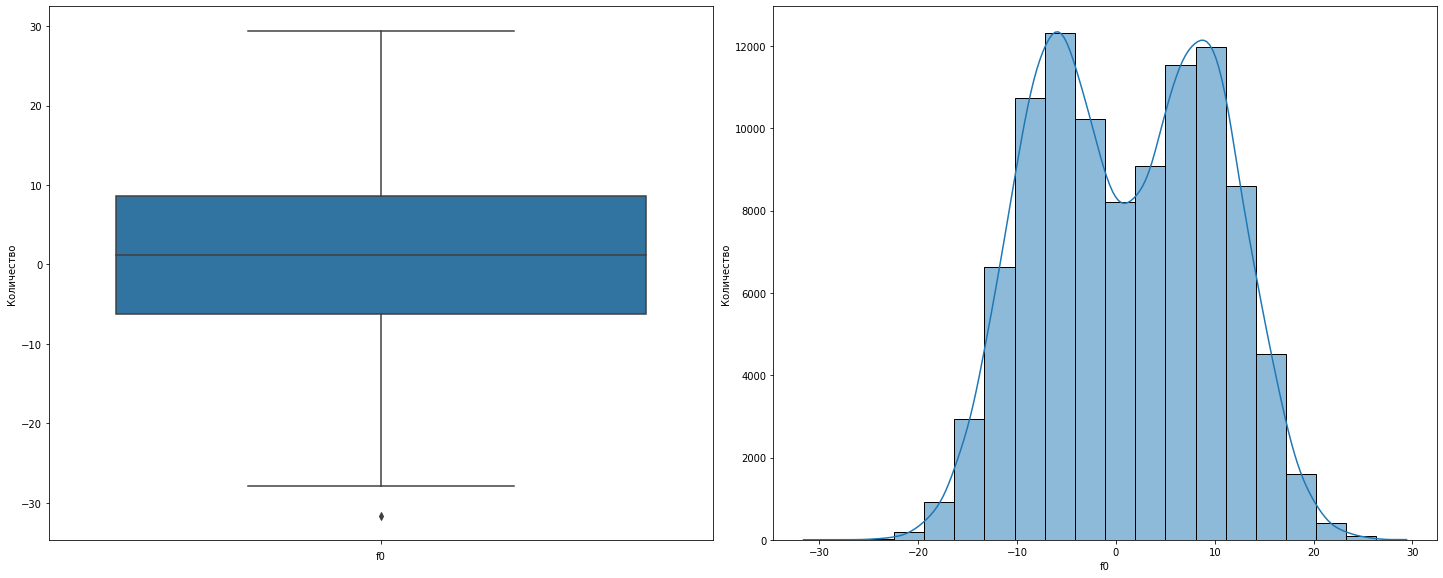

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=0.978, p=0.000\n'

Probably not Gaussian


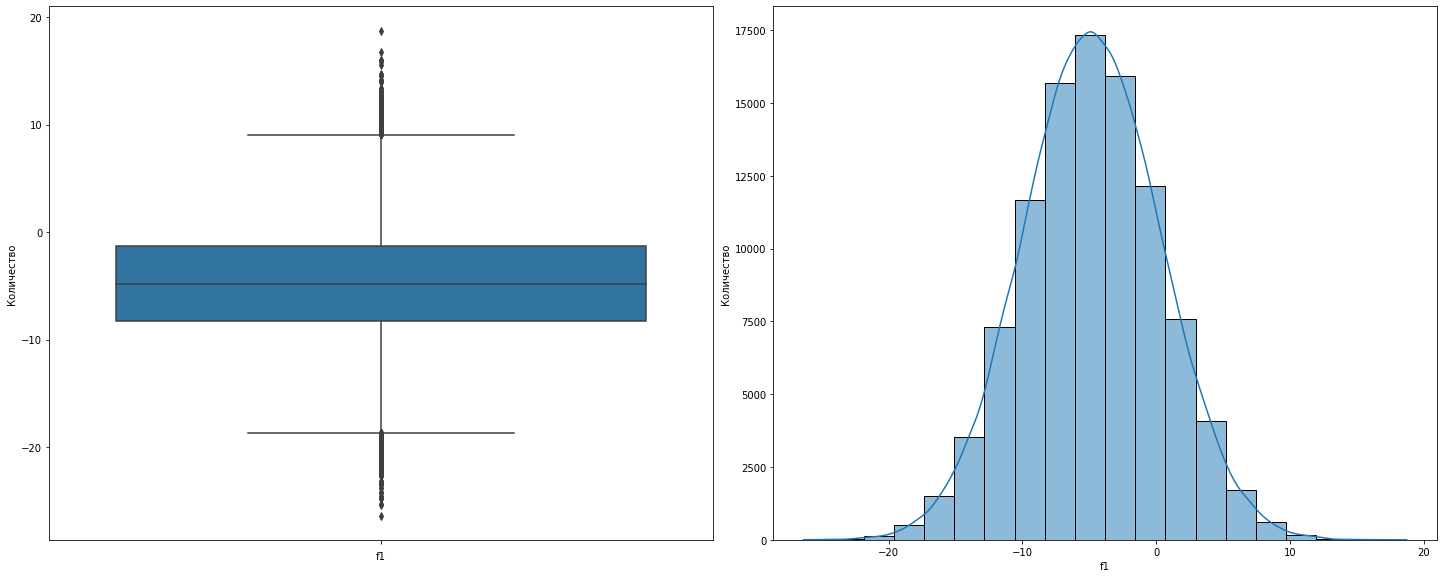

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=1.000, p=0.304\n'

Probably Gaussian


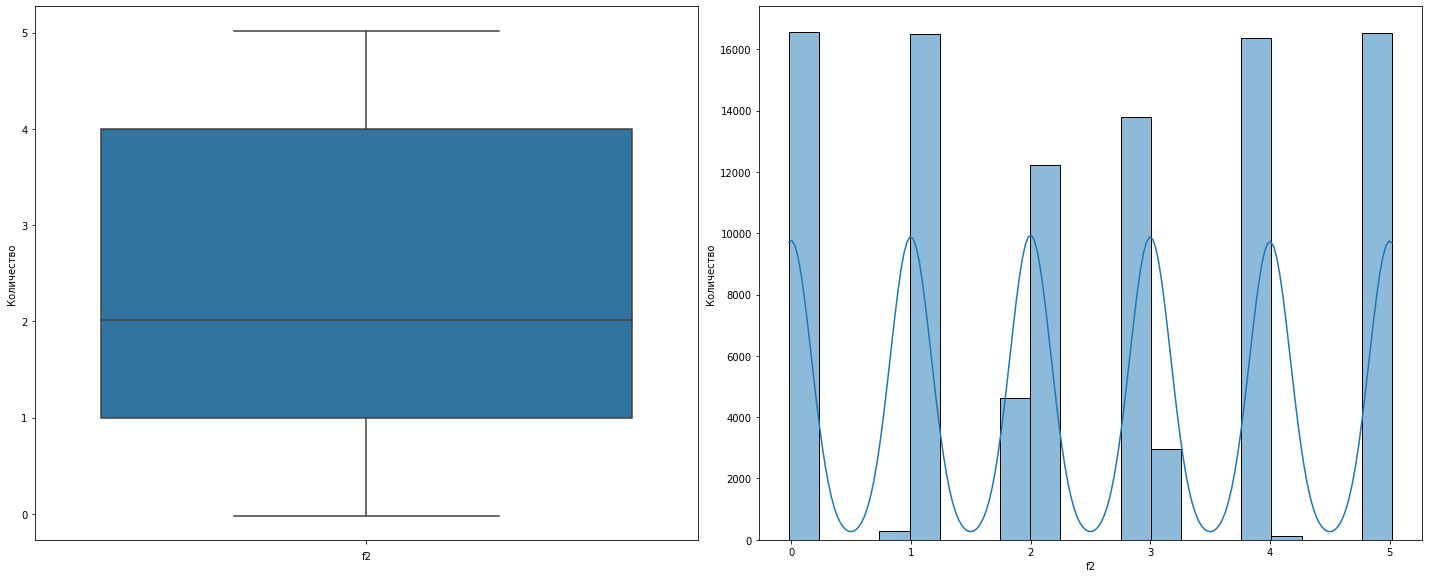

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=0.908, p=0.000\n'

Probably not Gaussian
"Пара графиков для таблицы geo_data_2


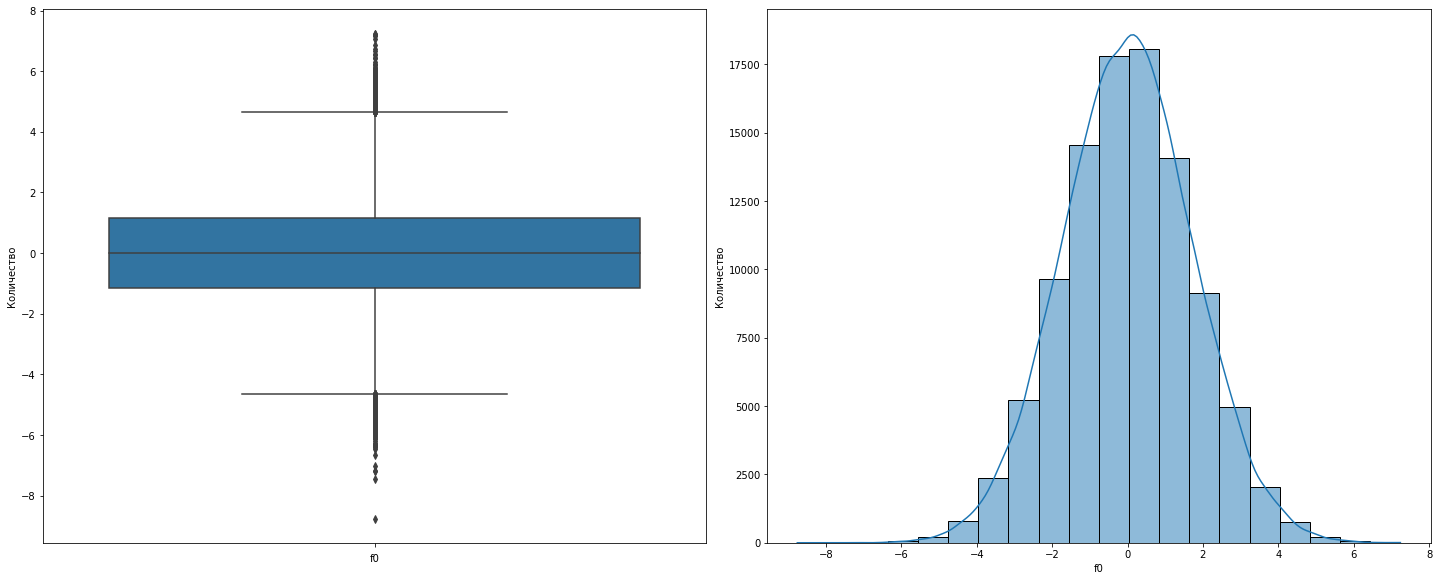

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=1.000, p=0.642\n'

Probably Gaussian


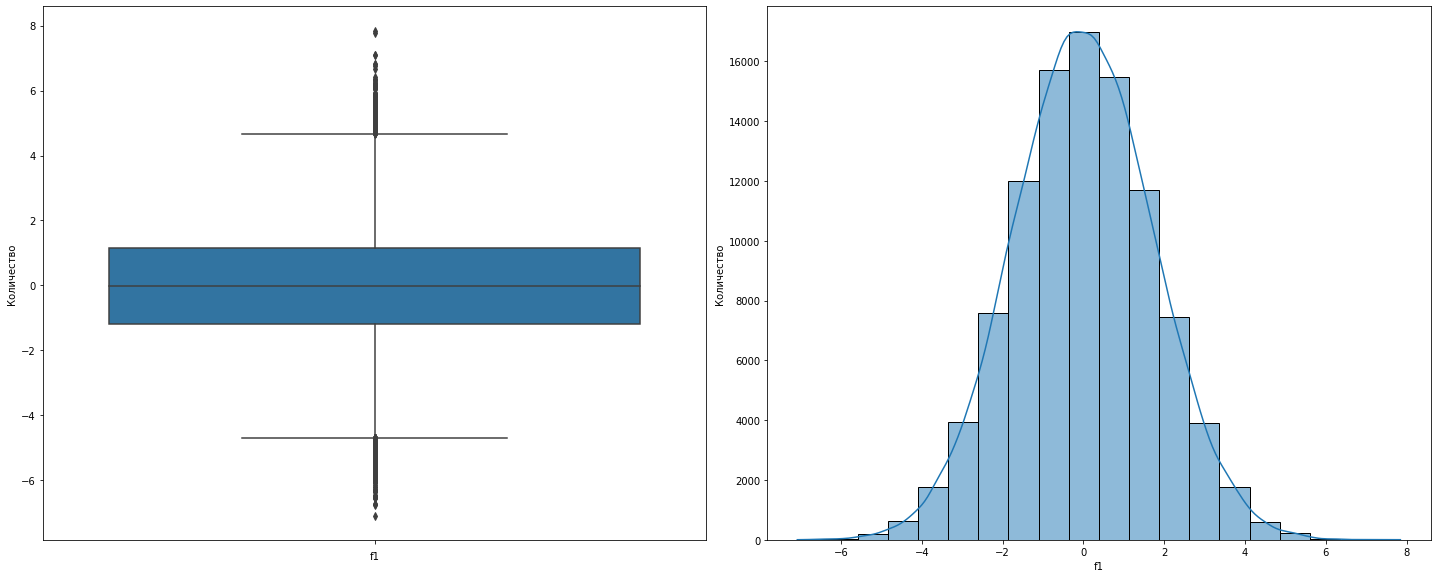

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=1.000, p=0.990\n'

Probably Gaussian


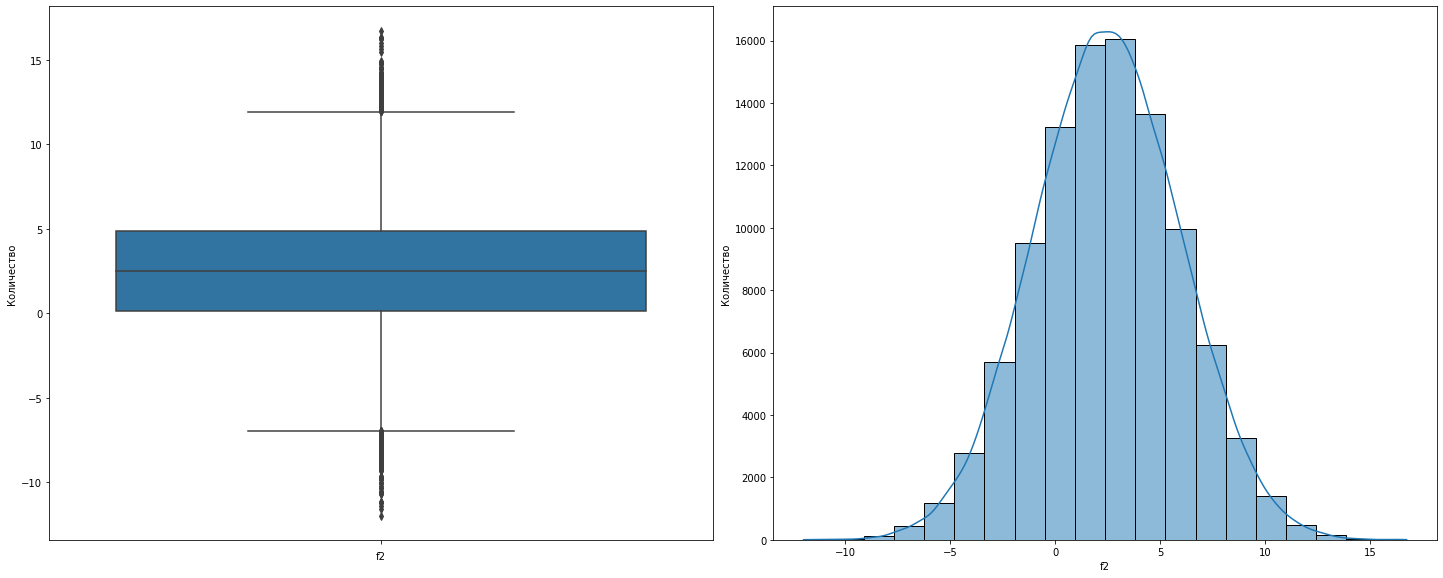

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'stat=1.000, p=0.004\n'

Probably not Gaussian


In [10]:
col_num = ['f0', 'f1', 'f2']
for f in DF_NAMES:
    print(f'"Пара графиков для таблицы {f}')
    for c in col_num:
        if c != 'id':
            fig, axes = plt.subplots(1,2, figsize=(20, 8), constrained_layout=False)
            fig.tight_layout(h_pad=10,w_pad=3)
            axes = axes.ravel()
            ax = sns.histplot(x=c, data = globals()[f], bins=20, kde=True)
            ax.set(xlabel=c, ylabel='Количество')
            ax = sns.boxplot(y=c, data=globals()[f], ax=axes[0])
            ax.set(xlabel=c, ylabel='Количество')
            plt.show()
            #print(kstest(globals()[f][c], 'norm'))

            stat, p = shapiro(globals()[f][c])
            display('stat=%.3f, p=%.3f\n' % (stat, p))
            #print(stat, p)
            if p > 0.01:
                print('Probably Gaussian')
            else:
                print('Probably not Gaussian')

**Выводы:** 
1. Не все показатели демонстрируют нормальное распределение. 
2. Признак f2 очень сильно коррелирует с product, особенно во втором датасете.

## 2. Обучение и проверка модели

Для каждого датасета создадим две переменные:
    
features — признаки, влияющие на целевой признак
target — целевой признак

In [11]:
# признаки для 1 региона
features_0 = geo_data_0.drop(['product'] , axis = 1)
target_0 = geo_data_0['product']

# признаки для 2 региона
features_1 = geo_data_1.drop(['product'], axis = 1)
target_1 = geo_data_1['product']

# признаки для 3 региона
features_2 = geo_data_2.drop(['product'] , axis = 1)
target_2 = geo_data_2['product']

Разделим данные на обучающую и валидационную выборки в соотношении 75:25:

In [12]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0,
                                                                                        random_state=777,
                                                                                        test_size = 0.25)
print('1 регион')
print('Доля обучающей выборки: {:.0%}'.format(len(features_train_0)/len(geo_data_0)))
print('Количество элементов в обучающей выборке: {}'.format(features_train_0.shape[0]))
print()

                                                                                        
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1,
                                                                                        random_state=777,
                                                                                        test_size = 0.25)   
print('2 регион')
print('Доля обучающей выборки: {:.0%}'.format(len(features_train_1)/len(geo_data_1)))
print('Количество элементов в обучающей выборке: {}'.format(features_train_1.shape[0]))
print()
                                                                                        
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2,
                                                                                        random_state=777,
                                                                                        test_size = 0.25)    
print('3 регион')
print('Доля обучающей выборки: {:.0%}'.format(len(features_train_2)/len(geo_data_2)))
print('Количество элементов в обучающей выборке: {}'.format(features_train_2.shape[0]))

1 регион
Доля обучающей выборки: 75%
Количество элементов в обучающей выборке: 75000

2 регион
Доля обучающей выборки: 75%
Количество элементов в обучающей выборке: 75000

3 регион
Доля обучающей выборки: 75%
Количество элементов в обучающей выборке: 75000


Для расчёта среднего запаса предсказанного сырья и RMSE напишем функцию lin_model, в качестве модели используем линейную регрессию:

In [13]:
def lin_model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression(n_jobs = -1)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse =mse**0.5
    return predicted_valid, mse,rmse

In [14]:
predicted_valid_0, mse_0, rmse_0 = lin_model(features_train_0, target_train_0, features_valid_0, target_valid_0)
#predicted_valid_0 = pd.DataFrame(predicted_valid_0)
#predicted_valid_0
# сразу делаем датасет для расчета прибыли по 1 региону
data_profit_0 = features_valid_0
data_profit_0['product'] = target_valid_0
data_profit_0['product_predict'] = predicted_valid_0
data_profit_0.head()

/tmp/ipykernel_31/1403097549.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_profit_0['product'] = target_valid_0
/tmp/ipykernel_31/1403097549.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_profit_0['product_predict'] = predicted_valid_0


,f0,f1,f2,product,product_predict
id,,,,,
59u18,0.113718,1.088792,1.652847,103.823665,73.602223
6oPYU,-0.964788,0.168978,1.157154,127.148609,79.131512
8Hjpx,1.047647,0.368769,6.921124,151.007768,122.033246
qStbm,2.041288,0.418637,-0.718987,176.320797,74.697464
hLcUa,0.510126,0.822430,7.980055,109.722362,120.607144


In [15]:

print('1-й регион:')
print('Средний запас предсказанного сырья: {:.1f} тыс. баррелей'.format(predicted_valid_0.mean()))
print('MSE: {:.1f}'.format(mse_0))
print('RMSE: {:.1f}'.format(rmse_0))
print("R2:", round(r2_score(target_valid_0, predicted_valid_0), 2))
print()

1-й регион:
Средний запас предсказанного сырья: 92.7 тыс. баррелей
MSE: 1443.4
RMSE: 38.0
R2: 0.27



In [16]:
predicted_valid_1,mse_1, rmse_1 = lin_model(features_train_1, target_train_1, features_valid_1, target_valid_1)
# сразу делаем датасет для расчета прибыли по 1 региону
data_profit_1 = features_valid_1
data_profit_1['product'] = target_valid_1
data_profit_1['product_predict'] = predicted_valid_1
data_profit_1.head()

/tmp/ipykernel_31/1605213905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_profit_1['product'] = target_valid_1
/tmp/ipykernel_31/1605213905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_profit_1['product_predict'] = predicted_valid_1


,f0,f1,f2,product,product_predict
id,,,,,
sq93B,-5.797310,-7.891428,-0.002496,3.179103,2.599524
xTKhw,-4.410573,-2.637445,1.991988,57.085625,56.040409
CY65t,-1.601939,-3.131760,3.999079,110.992147,109.736365
MSAp3,3.891764,8.816695,4.996650,134.766305,135.571811
KiKCa,10.639509,-2.209882,3.998733,107.813044,107.931082


In [17]:

print('2-й регион:')
print('Средний запас предсказанного сырья: {:.2f} тыс. баррелей'.format(predicted_valid_1.mean()))
print('MSE: {:.1f}'.format(mse_1))
print('RMSE: {:.1f}'.format(rmse_1))
print("R2:", r2_score(target_valid_1, predicted_valid_1))
print()

2-й регион:
Средний запас предсказанного сырья: 69.75 тыс. баррелей
MSE: 0.8
RMSE: 0.9
R2: 0.9996232950483743



In [18]:
predicted_valid_2, mse_2, rmse_2 = lin_model(features_train_2, target_train_2, features_valid_2, target_valid_2)
data_profit_2 = features_valid_2
data_profit_2['product'] = target_valid_2
data_profit_2['product_predict'] = predicted_valid_2
data_profit_2.head()

/tmp/ipykernel_31/464524579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_profit_2['product'] = target_valid_2
/tmp/ipykernel_31/464524579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_profit_2['product_predict'] = predicted_valid_2


,f0,f1,f2,product,product_predict
id,,,,,
TBR0w,1.376002,1.463339,6.733221,123.794915,119.375300
vHA0H,-3.111655,-0.504846,2.959657,165.999478,97.671540
KimQ9,-0.294701,1.825014,-1.698878,46.103174,70.914419
G1355,-2.994424,0.707902,4.107101,66.515691,104.252505
AMCZs,-1.476900,0.796603,-1.844348,40.318187,70.077071


In [19]:

print('3-й регион:')
print('Средний запас предсказанного сырья: {:.1f} тыс. баррелей'.format(predicted_valid_2.mean()))
print('MSE: {:.1f}'.format(mse_2))
print('RMSE: {:.1f}'.format(rmse_2))
print("R2:", round(r2_score(target_valid_2, predicted_valid_2), 2))
print()

3-й регион:
Средний запас предсказанного сырья: 95.0 тыс. баррелей
MSE: 1618.5
RMSE: 40.2
R2: 0.2



**Выводы:**
1. Высокий коэф. детерминации во втором регионе, говорит о том, что модель предсказывает очень хорошо, но это, очевидно, связано с тем, что признак f2 коррелирует с целевым признаком с коэффициентом 1.0.
2. Модели первого региона и третьего показывают очень плохие результаты. Не стоит использовать их для выбора скважины в регионе.

## 3. Подготовка к расчёту прибыли

- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.

- Один баррель сырья приносит 450 рублей дохода.

- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.

- Среди них выбирают регион с наибольшей средней прибылью.

Все ключевые значения для расчётов сохраним в отдельных переменных:

In [20]:
points= 500 # всего точек для исследований
best_points = 200 # кол-во лучших скважин для разработки и освоения (и для расчета прибыли)
budget = 10000000000 # бюджет всего проекта
profit_from_one_barrel = 450 # Прибыль с одного барреля сырья 450 рублей
profit_from_one_product = 450000   #Доход с каждой единицы продукта 450 000 рублей
risk_point = 0.025 # верхний порог вероятности убытко (для нахождения регионов, в которых вероятность убытков меньше 2.5%)



In [21]:
#Посчитаем цену за бурение одной скважины
best_point_cost = budget / best_points
print('Бюджет на бурение одной скважины - ', best_point_cost,'руб')

Бюджет на бурение одной скважины -  50000000.0 руб


In [22]:
#Посчитаем Достаточный (минимальный) объем сырья для безубыточной разработки новой скважины
min_product_mean  = best_point_cost/profit_from_one_product
print('Минимально необходимый запас сырья (продукта) на одной скважине - {:.1f} тыс. баррелей'.format(min_product_mean))

Минимально необходимый запас сырья (продукта) на одной скважине - 111.1 тыс. баррелей


**Вывод:** Самый большой средний запас предсказанного сырья - в 3-м регионе - 95.0 тыс. баррелей, и его недостаточно для рандомного бурения скважин (с условием безубыточности), поэтому есть необходимость выбирать только скважины с самыми большими запасами (топ 200).

In [23]:
#Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели. 

def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (450000 * selected.sum() - (budget))

In [24]:
# переведем предсказанные значения из array в DataFrame, чтобы можно было их отсортировать
#print(predicted_valid_0)
predicted_valid_0 = pd.DataFrame(predicted_valid_0) 
predicted_valid_1 = pd.DataFrame(predicted_valid_1)
predicted_valid_2 = pd.DataFrame(predicted_valid_2)
#print(predicted_valid_0.head())

In [25]:
#Посчитаем прибыль на каждый регион
print('Прибыль первого региона : {:.2f} млрд рублей'.format(profit(target_valid_0, predicted_valid_0[0],200)/10**9))
print('Прибыль второго региона : {:.2f} млрд рублей'.format(profit(target_valid_1, predicted_valid_1[0],200)/10**9))
print('Прибыль третьего региона: {:.2f} млрд рублей'.format(profit(target_valid_2, predicted_valid_2[0],200)/10**9))

Прибыль первого региона : 3.43 млрд рублей
Прибыль второго региона : 2.42 млрд рублей
Прибыль третьего региона: 2.27 млрд рублей


**Вывод:** Потенциально самый прибыльный регион - первый, но нужно еще учесть риск убытков.

## 4. Расчёт прибыли и рисков 

In [26]:
#Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для первого региона
profits = []
final_profits = []
for i in range(1000):
    target_subsample = data_profit_0['product'].sample(n=500, replace=True, random_state=RANDOM_STATE)
    
    #print(target_subsample.index)
    probs_subsample = data_profit_0['product_predict'][target_subsample.index]
    #print('Target subsample = ', target_subsample.head())
    #print('PROBS_subsample = ', probs_subsample.head())
    profits.append(profit(target_subsample, probs_subsample, 200))
    
profits = pd.Series(profits)
lower = profits.quantile(0.025)
mean = profits.mean()
risks = (profits < 0).mean()* 100
print("Средняя прибыль:", mean/10**9) # переводим в миллиарды
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (profits.quantile(0.025), profits.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
final_profits.append(('region 1', mean/10**9, lower/10**9, confidence_interval, risks))
final_profits

Средняя прибыль: 0.48985298130800975
2.5%-квантиль: -0.05150576458617811
Риск: 3.6999999999999997
95% доверительный интервал:  (-51505764.58617811, 1046143411.3694127)


[('region 1',
  0.48985298130800975,
  -0.05150576458617811,
  (-51505764.58617811, 1046143411.3694127),
  3.6999999999999997)]

In [27]:
#Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для второго региона
profits = []

for i in range(1000):
    target_subsample = data_profit_1['product'].sample(n=500, replace=True, random_state=RANDOM_STATE)
    
    #print(target_subsample.index)
    probs_subsample = data_profit_1['product_predict'][target_subsample.index]
    profits.append(profit(target_subsample, probs_subsample, 200))
    
profits = pd.Series(profits)
lower = profits.quantile(0.025)
mean = profits.mean()
risks = (profits < 0).mean()* 100
print("Средняя прибыль:", mean/10**9) # переводим в миллиарды
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (profits.quantile(0.025), profits.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
final_profits.append(('region 2', mean/10**9, lower/10**9, confidence_interval, risks))
final_profits

Средняя прибыль: 0.5756988004170859
2.5%-квантиль: 0.13523889234541045
Риск: 0.4
95% доверительный интервал:  (135238892.34541044, 1027755183.1813608)


[('region 1',
  0.48985298130800975,
  -0.05150576458617811,
  (-51505764.58617811, 1046143411.3694127),
  3.6999999999999997),
 ('region 2',
  0.5756988004170859,
  0.13523889234541045,
  (135238892.34541044, 1027755183.1813608),
  0.4)]

In [28]:
#Техникой bootstrap посчитаем среднюю прибыль , 95% доверительный интервал и риск убытков для третьего региона
profits = []

for i in range(1000):
    target_subsample = data_profit_2['product'].sample(n=500, replace=True, random_state=RANDOM_STATE)
    
    #print(target_subsample.index)
    probs_subsample = data_profit_2['product_predict'][target_subsample.index]
    profits.append(profit(target_subsample, probs_subsample, 200))
    
profits = pd.Series(profits)
lower = profits.quantile(0.025)
mean = profits.mean()
risks = (profits < 0).mean()* 100
print("Средняя прибыль:", mean/10**9) # переводим в миллиарды
print("2.5%-квантиль:", lower/10**9)
print("Риск: {}".format(risks))
confidence_interval = (profits.quantile(0.025), profits.quantile(0.975))
print('95% доверительный интервал: ', confidence_interval)
final_profits.append(('region 3', mean/10**9, lower/10**9, confidence_interval, risks))
final_profits


Средняя прибыль: 0.373968047357523
2.5%-квантиль: -0.19596319040312046
Риск: 10.100000000000001
95% доверительный интервал:  (-195963190.40312046, 924628256.6981916)


[('region 1',
  0.48985298130800975,
  -0.05150576458617811,
  (-51505764.58617811, 1046143411.3694127),
  3.6999999999999997),
 ('region 2',
  0.5756988004170859,
  0.13523889234541045,
  (135238892.34541044, 1027755183.1813608),
  0.4),
 ('region 3',
  0.373968047357523,
  -0.19596319040312046,
  (-195963190.40312046, 924628256.6981916),
  10.100000000000001)]

**Вывод:** Самый лучший регион - исходя из предоставленных синтетических данных - второй, т.к. прибыль наибольшая, риск наименьший.

**Общий вывод:**
Мы получили три датасета - три разные региона для прогнозирования объема сырья и прибыли. Все датасеты были хорошо подготовлены, не имелось никаких дубликатов, пустых значений. Но второй датасет оказался сильно отличимым от других, у него в столбце product были лишь 12 уникальных значений. Что позволило нашей модели хорошо делать прогнозы по второму региону. Можно ли использовать эту модель - вопрос открытый, т.к. изначальные данные (всего 12 уникальных значений целевого признака) сомнительны на фоне данных двух других регионов.

Исходя из всех результатов моделей мы получили такие результаты:

Регион 1: RMSE : 38 ; Score 0.27
Регион 2: RMSE : 0.9 ; Score 0.99
Регион 3: RMSE : 40.2 ; Score 0.2

Провели расчет прибыли и пришли к выводу, что минимальный объем сырья должен составлять 111 тыс баррелей. Наши средние показатели трех регионов не доходят до минимального порога.

Исходя из всех полученных данных: второй регион имеет наибольшие шансы на получение прибыли. 